# Classification

**Classification** is the problem of predicting the class of given data points. Classes are also called targets, labels or categories. Classification is applied by training a classifier algorithm on training data to predict how new data is classified.

Actually, the first neural net model that we created in chapter 2 was a classification model. This model was used to classify digits 0-9 from the simple **load_digits** dataset. We modeled the **MNIST** dataset in chapter 3,  which is also a classification model. This model was also used to classify digits 0-9, but the data images are much more complex than load_digits and MNIST contains significantly more data.

So, we've already introduced classification at a superficial level. However, in this chapter, we build more sophisticated models based on more complex datasets.

Enable the GPU (if not already enabled):
1.	click Runtime in the top left menu
2.	click Change runtime type from the drop-down menu
3.	choose GPU from the Hardware accelerator drop-down menu
4.	click SAVE

Test if GPU is active:

In [3]:
import tensorflow as tf

# display tf version and test if GPU is active

tf.__version__, tf.test.gpu_device_name()

('2.3.0', '/device:GPU:0')

Import the *tensorflow* library. If '/device:GPU:0' is displayed, the GPU is active. If '..' is displayed, the regular CPU is active.

# Fashion-MNIST Dataset

**Fashion-MNIST** is a dataset of Zalando Research article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement of the original MNIST dataset for benchmarking machine learning algorithms.

Fashion-MNIST is a good alternative to MNIST because MNIST is too easy to classify. That is, most pairs of MNIST digits can be distinguished pretty well by just a few pixels. Also, MNIST is overused. Many data scientists believe that we should start benchmarking with a more difficult dataset.

Zalando Research is an organization that utilizes an agile design process that combines invaluable human experience with the power of Machine Learning. Zalando concentrates on exploring novel ways to use generative models in fashion design for rapid visualizations and prototyping.

## Load Fashion-MNIST

Since Fashion-MNIST is a **tfds.data.Dataset**, we can easily load it with **tfds.load()**. To get a list of all tfds datasets, just run the **tfds.list_builders()** method as demonstrated in chapter 3.

Load train and test examples as a tf.data.Dataset:

In [5]:
import tensorflow_datasets as tfds

train, info = tfds.load('fashion_mnist', split='train',
                        with_info=True, shuffle_files=True)
test = tfds.load('fashion_mnist', split='test')

Since we already have *info* from the train data, we don't need it again for the test data.

Let's verify that both train and test data are tensors and get their shape:

In [6]:
train.element_spec, test.element_spec

({'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
  'label': TensorSpec(shape=(), dtype=tf.int64, name=None)},
 {'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
  'label': TensorSpec(shape=(), dtype=tf.int64, name=None)})

Notice that the 28 x 28 x 1 shape is 3D. So, each image consists of 28 x 28 pixels. The '1' means that images are grayscale.

## Display Information about the Dataset

Let's display information about the dataset:

In [7]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

Wow! We now have a lot of information about the dataset. We know the name, description, and homepage of the dataset. We also know the shape and datatype of feature images and labels. We know that there are 70,000 examples with train and test set splits of 60,000 and 10,000 respectively. And, there is even more information provided!

## Extract Class Labels

Let's extract some useful information from the **info** object:

In [8]:
br = '\n'

num_classes = info.features['label'].num_classes
class_labels = info.features['label'].names
print ('number of classes:', num_classes, br)
print ('class labels:', class_labels)

number of classes: 10 

class labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


From simple code, we are able to ascertain the number of classes and their corresponding class labels.

## Display Samples from the Dataset

Now, let's display some examples:

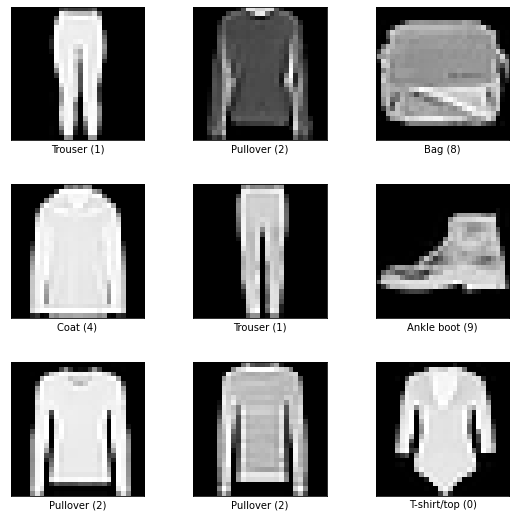

In [9]:
fig = tfds.show_examples(train, info)

**tfds.show_examples()** allows us to visualize images (and labels) from an image classification dataset. To use this method, we need the dataset and information about the dataset. Since we just created variable *info* with method **info** from tfds.builder, we can show some examples.


## Build a Custom Function to Display Samples

Once we have the label names, we can build a custom function to display samples from the train dataset. We can even change colors!

In [10]:
import matplotlib.pyplot as plt, numpy as np

def display_samples(data, num, cmap):
  for example in data.take(num):
    image, label = example['image'], example['label']
    print ('Label:', class_labels[label.numpy()], end=', ')
    print ('Index:', label.numpy())
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32),
               cmap=plt.get_cmap(cmap))
    plt.show()

Label: Pullover, Index: 2


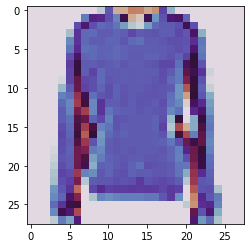

Label: Trouser, Index: 1


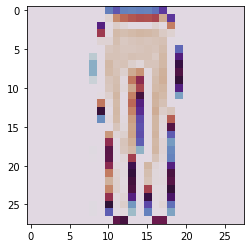

In [11]:
# choose colormap by changing 'indx'

indx = 5
cmap = ['coolwarm', 'viridis', 'plasma',
        'seismic', 'copper', 'twilight']
samples = 2
display_samples(train, samples, cmap[indx])

## Build a Custom Function to Display a Grid

Take 30 samples from the train set:

In [12]:
num = 30
images, labels = [], []
for example in train.take(num):
  image, label = example['image'], example['label']
  images.append(tf.squeeze(image.numpy()))
  labels.append(tf.squeeze(label.numpy()))

To enable image plotting, we must remove (or squeeze) the 1 dimension from the image matrix.

Build the function:

In [13]:
def display_grid(feature, target, n_rows, n_cols, cl):
  plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
  for row in range(n_rows):
    for col in range(n_cols):
      index = n_cols * row + col
      plt.subplot(n_rows, n_cols, index + 1)
      plt.imshow(feature[index], cmap='binary',
                 interpolation='nearest')
      plt.axis('off')
      plt.title(cl[target[index]], fontsize=12)
  plt.subplots_adjust(wspace=0.2, hspace=0.5)

Invoke the function:

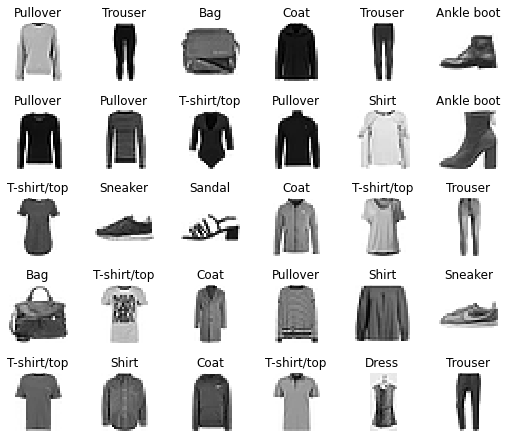

In [14]:
rows = 5
cols = 6
display_grid(images, labels, rows, cols, class_labels)

## Pinpoint Metadata

We easily can pinpoint metadata with DatasetInfo as so:

In [15]:
print ('Number of training examples:', end=' ')
print (info.splits['train'].num_examples)

print ('Number of test examples:', end=' ')
print (info.splits['test'].num_examples)

Number of training examples: 60000
Number of test examples: 10000


## Build the Input Pipeline

In [16]:
BATCH_SIZE = 128
SHUFFLE_SIZE = 5000

train_f1 = train.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
train_f2 = train_f1.map(lambda items: (
    tf.cast(items['image'], tf.float32) / 255., items['label']))
train_fs = train_f2.cache().prefetch(1)

test_f1 = test.batch(BATCH_SIZE)
test_f2 = test_f1.map(lambda items: (
    tf.cast(items['image'], tf.float32) / 255., items['label']))
test_fs = test_f2.cache().prefetch(1)

We create the rest of the input pipeline by adding shuffling, batching, scaling, caching, and prefetching. Notice how we scale images by mapping with a lambda function. Adding **cache()** increases performance on TFDS because data is read and written only once rather than during each epoch. Adding **prefectch(1)** is a good idea because it adds efficiency to the batching process. That is, while our training algorithm is working on one batch, TensorFlow is working on the dataset in parallel to get the next batch ready. So, prefectch can dramatically improve training performance.

Let's verify that the train and test sets were created correctly:

In [17]:
train_fs.element_spec, test_fs.element_spec

((TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

We can see that the image shapes are 28 x 28 x 1. The 1 value means that the images are grayscale. That is, images are just in black and white.

## Build the Model

Let's build a simple neural net model:

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# clear previous model and generate a seed
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

model = Sequential([
  Flatten(input_shape=[28, 28, 1]),
  Dense(512, activation='relu'),
  Dropout(0.4),
  Dense(10, activation='softmax')
])

Display summary of the model:

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Compile the Model: 

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

We can also display information about the model's layers:

In [21]:
model.layers

## Train the Model

In [22]:
epochs = 10
history = model.fit(train_fs, epochs=epochs,
                    verbose=1, validation_data=test_fs)

Epoch 1/10
469/469 [==============================] - 7s 16ms/step - loss: 0.5485 - accuracy: 0.8069 - val_loss: 0.4461 - val_accuracy: 0.8421
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4075 - accuracy: 0.8534 - val_loss: 0.3870 - val_accuracy: 0.8623
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3714 - accuracy: 0.8658 - val_loss: 0.3717 - val_accuracy: 0.8672
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3505 - accuracy: 0.8731 - val_loss: 0.3527 - val_accuracy: 0.8722
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3360 - accuracy: 0.8767 - val_loss: 0.3572 - val_accuracy: 0.8699
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3229 - accuracy: 0.8827 - val_loss: 0.3527 - val_accuracy: 0.8737
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3118 - accuracy: 0.8849 - val_loss: 0.3460 - val_accuracy: 0.8755
Epoch

# Generalize on Test Data

Although model fit information provides validation loss and accuracy values during training, it is always a good idea to explictly evaluate the model on test data because accuracy and loss values can differ.

In [24]:
print('Test accuracy:', end=' ')
test_loss, test_acc = model.evaluate(test_fs, verbose=2)

Test accuracy: 79/79 - 0s - loss: 0.3336 - accuracy: 0.8806


## Visualize Performance

The **fit** method automatically records the history of the training process as a dictionary. So, we can assign training to a variable. In this case, we assigned it to **history**. The  **history** attribute of the variable contains the dictionary information. We display the dictionary keys to inform us how to plot the results.

Display the contents of the dictionary:

In [25]:
hist_dict = history.history
print (hist_dict, '\n')
print (hist_dict.keys())

{'loss': [0.5485366582870483, 0.4075414836406708, 0.3714368939399719, 0.3505440354347229, 0.3359646797180176, 0.32289835810661316, 0.31179216504096985, 0.30424413084983826, 0.2942598760128021, 0.2886325716972351], 'accuracy': [0.8069166541099548, 0.8533999919891357, 0.8657833337783813, 0.873116672039032, 0.8766833543777466, 0.8827333450317383, 0.8849166631698608, 0.8871333599090576, 0.8914833068847656, 0.8917666673660278], 'val_loss': [0.4460850954055786, 0.3870086967945099, 0.37166330218315125, 0.3527243137359619, 0.3571884334087372, 0.352688729763031, 0.3460088074207306, 0.33107730746269226, 0.3292427659034729, 0.33363524079322815], 'val_accuracy': [0.8421000242233276, 0.8622999787330627, 0.8672000169754028, 0.8722000122070312, 0.8698999881744385, 0.8737000226974487, 0.8755000233650208, 0.8809999823570251, 0.8823000192642212, 0.8805999755859375]} 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


The dictionary **history.history** contains loss, accuracy, val_loss, and val_accuracy metrics that the model measures at the end of each epoch on the training set and validation set.

The **params** variable provides all parameters involved with training.

In [26]:
history.params

{'epochs': 10, 'steps': 469, 'verbose': 1}

The epoch method displays the number of epochs:

In [27]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Plot training performance:

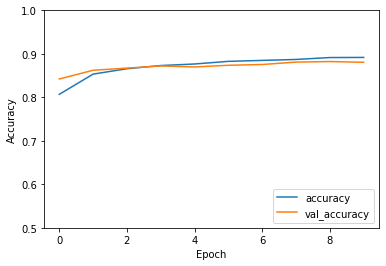

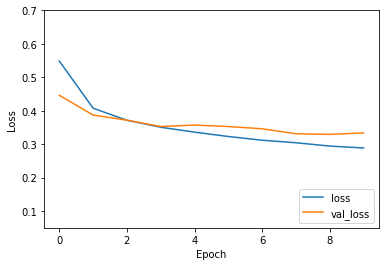

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.05, .7])
plt.legend(loc='lower right')
plt.show()

We don't have much overfitting.

We can also use pandas to plot training performance:

(0.0, 1.0)

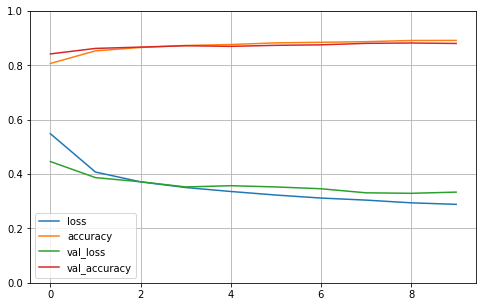

In [29]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

## Predict Labels for Test Images

Now that we have a trained model, we can make predictions based on test images. We predict from test images because the model sees these images as **new** data.

In [30]:
tf.random.set_seed(0)

predictions = model.predict(test_fs)

Since Fashion-MNIST has 10 class labels, each prediction is an array of 10 numbers that represent the model's *confidence* that the image corresponds to each of the 10 different articles of clothing.

Now, let's take a look at the first prediction from test_fs:

In [31]:
predictions[0]

array([6.4809519e-06, 4.6060009e-07, 5.8255694e-03, 8.0573528e-07,
       9.6868134e-01, 3.0973044e-11, 2.5484372e-02, 1.5473612e-11,
       1.0111129e-06, 3.3604508e-11], dtype=float32)

It's kind of hard to tell which of the values has the highest number by looking at the array of numpy values. So, let's round the numbers in the predictions array:

In [32]:
np.round(predictions[0], 2)

array([0.  , 0.  , 0.01, 0.  , 0.97, 0.  , 0.03, 0.  , 0.  , 0.  ],
      dtype=float32)

We can directly derive the confidence we have in the first prediction with the following code:

In [33]:
c = 100*np.max(predictions[0])
c

96.86813354492188

Display the confidence:

In [34]:
'{:.2%}'.format(np.max(predictions[0]))

'96.87%'

Display the prediction for the first image::

In [35]:
np.argmax(predictions[0])

4

The prediction can only be between **0** and **9** because our target class consists of ten classes. We can use the 'class_labels' array that we created earlier to see the actual fashion article as so:

In [36]:
class_labels[np.argmax(predictions[0])]

'Coat'

Let's see the first actual test image so we can compare the two:

In [37]:
# take the first batch of images

for image, label in test_fs.take(1):
  label

class_labels[label[0].numpy()]

'Coat'

So, we take the first image from a batch of 128 images. If the prediction matches the test image, the prediction was correct.

## Build a Prediction Plot

Since we have a trained model, we can build a prediction plot.

Since we want to see how well the model works on new data, take 20 samples from the test set:

In [38]:
num = 30
images, labels = [], []
for example in test.take(num):
  image, label = example['image'], example['label']
  images.append(tf.squeeze(image.numpy()))
  labels.append(tf.squeeze(label.numpy()))

Build a custom function:

In [39]:
def display_test(feature, target, num_images,
                 n_rows, n_cols, cl, p):
  for i in range(num_images):
    plt.subplot(n_rows, 2*n_cols, 2*i+1)
    if cl[target[i]] != cl[np.argmax(p[i])]:
      plt.imshow(feature[i], cmap='Reds')
    else:
      plt.imshow(feature[i], cmap='Blues')
    val = 100*np.max(p[i])
    rounded = str(np.round(val, 2)) + '%'
    plt.title(cl[target[i]] + ' (' +\
              cl[np.argmax(p[i])] + ') ' +\
              rounded )
  plt.tight_layout()
plt.show()

Invoke function:

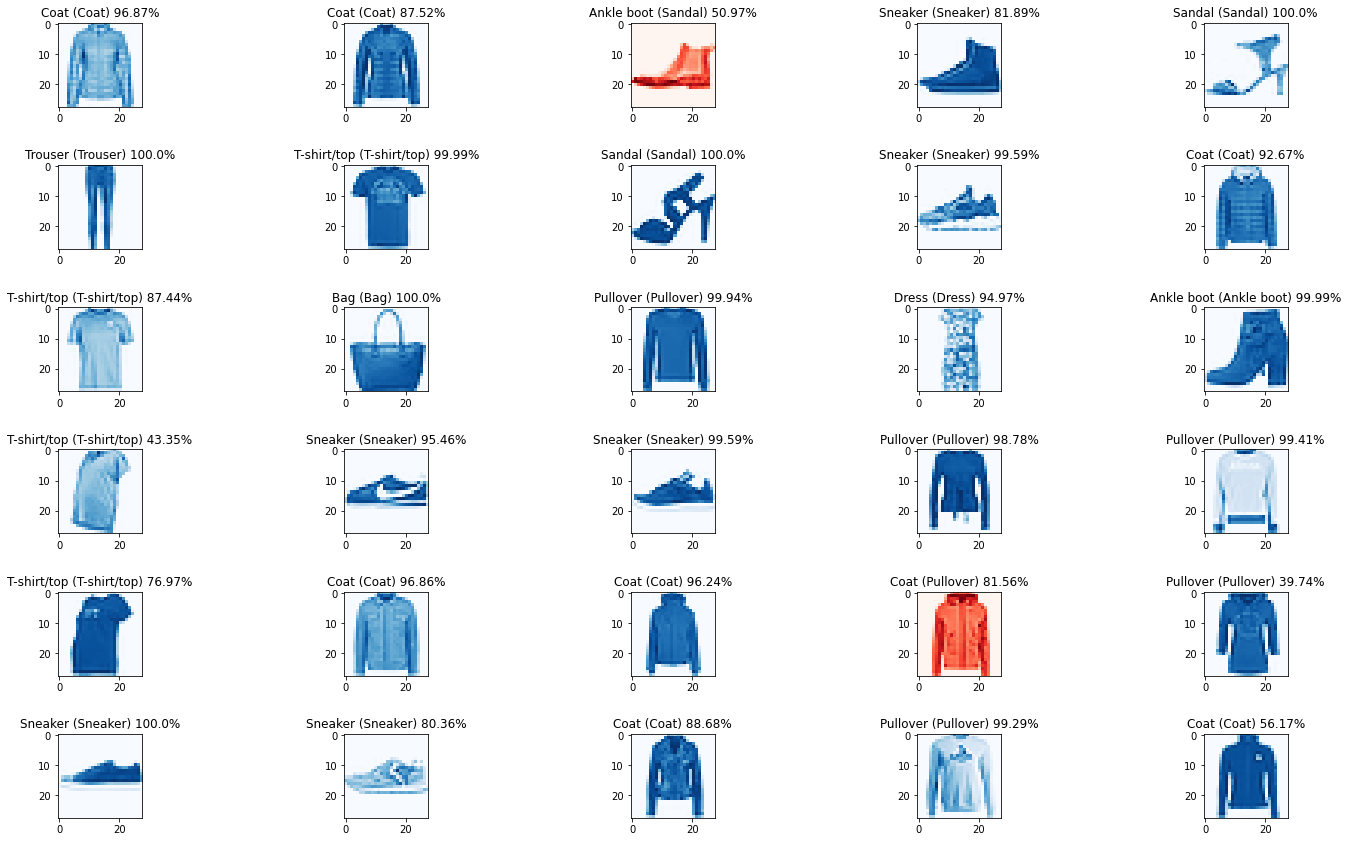

In [40]:
num_rows, num_cols = 6, 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
display_test(images, labels, num_images, num_rows,
             num_cols, class_labels, predictions)

Any clothing article in red means that the prediction was incorrect.

# Model the Keras Fashion-MNIST Dataset

Although TFDS are recommended for TensorFlow 2.x application, we show how to work with a Keras dataset because of its popularity in industry. The newness of TensorFlow 2.x means that it doesn't have the industry penetration of Keras.

Load Keras dataset:

In [41]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Explore the Data

Let's look at data shapes:

In [42]:
print ('train data:', br)
print (train[0].shape)
print (train[1].shape, br)
print ('test data:', br)
print (test[0].shape)
print (test[1].shape)

train data: 

(60000, 28, 28)
(60000,) 

test data: 

(10000, 28, 28)
(10000,)


As we can see, train data consists of 60000 28x28 feature images and 60000 labels. And, test data consists of 10000 28x28 feature images and 10000 labels. Notice that train images are contained in train[0] and train labels are contained in train[1].

So, let's see what the first image represents:

In [43]:
class_labels[train[1][0]]

'Ankle boot'

As noted earlier, we access train labels with **train[1]** and get the first image at index 0.

## Visualize the First Image

Let's see what the first image looks like. We can plot the first image with Matplotlib's imshow() function as so:

(-0.5, 27.5, 27.5, -0.5)

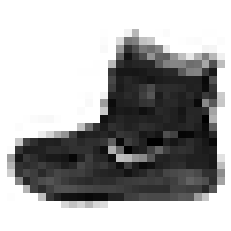

In [44]:
plt.imshow(train[0][0], cmap='binary')
plt.axis('off')

We can make this easier to view by assigning images and labels to their own variables:

In [45]:
train_images = train[0]
train_labels = train[1]

Let's plot the first image again based on the **train_images** variable:

(-0.5, 27.5, 27.5, -0.5)

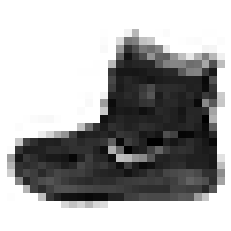

In [46]:
plt.imshow(train_images[0], cmap='binary')
plt.axis('off')

Now, we can access the representation of the first image as so:

In [47]:
class_labels[train_labels[0]]

'Ankle boot'

The labels are the class IDs (represented as uint8), from 0 to 9:

In [48]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

## Visualze a Sample of Images

We can look at a sample of the images in the dataset with a bit of code:

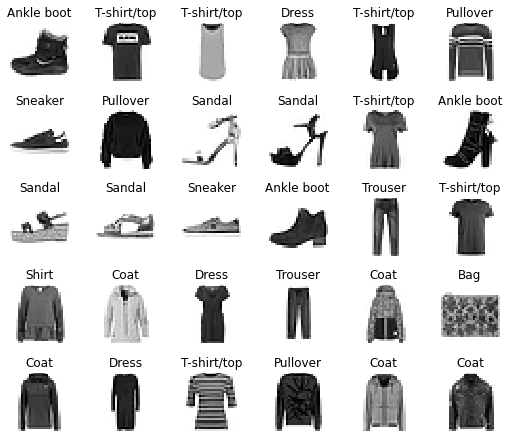

In [49]:
n_rows = 5
n_cols = 6
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(train_images[index], cmap='binary',
               interpolation='nearest')
    plt.axis('off')
    plt.title(class_labels[train_labels[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Prepare Data for Training

To prepare training data properly for TensorFlow consumption, we need to grab the images and labels and **scale** the images. Scaling ensures that each input parameter (a pixel, in our case) has a similar data distribution. The distribution of such data would resemble a Gaussian curve centered at zero. Scaling data makes convergence faster while training the network.

Since pixel data is represented by a range from [0, 255], we divide each of the feature images by 255 to scale. Once we have the images and labels, we can convert it to a tf.Tensor object with *from_tensor_slices*:

In [50]:
# add test images and labels to the mix

test_images, test_labels = test

train_pictures = train_images / 255.  # divide by 255 to scale
train_targets = train_labels.astype(np.int32)

test_pictures = test_images / 255.  # divide by 255 to scale
test_targets = test_labels.astype(np.int32)

print ('train images:', len(train_pictures))
print ('train labels:', len(train_targets), br)
print ('test images', len(test_pictures))
print ('test labels', len(test_targets))

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_pictures, train_targets))
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_pictures, test_targets))

train images: 60000
train labels: 60000 

test images 10000
test labels 10000


Now we can shuffle the data. We set BATCH_SIZE to 128 so the model will run faster than with a smaller batch size. You can experiment with this number and see what happens. We also set the SHUFFLE_BUFFER_SIZE to 5000 so the shuffle method will work well. Again, you can experiment with this number.

In [51]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 5000

train_ks = train_ds.shuffle(
    SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)
test_ks = test_ds.batch(BATCH_SIZE).prefetch(1)

Inspect tensors:

In [52]:
train_ks.element_spec, test_ks.element_spec

((TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))

## Build the model

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# clear previous model and generate a seed
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

model = Sequential([
  Flatten(input_shape=[28, 28]),
  Dense(512, activation='relu'),
  Dropout(0.4),
  Dense(10, activation='softmax')
])

It is always a good idea to clear any previous modeling sessions. Remember we already created a model and fit it earlier in the chapter. Also, planting a random seed ensures that the results are consistent. In machine learning, such consistency is called reproducibility. That is, the seed allows us to reproduce results in a consistent manner. You can use any integer value for the random seed number. We used **0** in our case. 

The **Flatten()** layer just flattens the 2D matrix of 28x28 images to a 1D array of 784 pixels. the next layer is the first true layer. It accepts input images into 128 neurons and performs *relu* activation. The final layer is the output layer. It accepts output from the input layer with 10 neurons that  represent the ten classes of clothing and performs *softmax* activation.

## Model Summary

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Compile the Model

In [55]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the Model

Fit the model. Passing a dataset of (feature, label) pairs is all that's needed for Model.fit and Model.evaluate.

In [56]:
history = model.fit(train_ks, epochs=10, validation_data=test_ks)

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5491 - accuracy: 0.8065 - val_loss: 0.4289 - val_accuracy: 0.8469
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4098 - accuracy: 0.8530 - val_loss: 0.3970 - val_accuracy: 0.8582
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3755 - accuracy: 0.8647 - val_loss: 0.3779 - val_accuracy: 0.8603
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3498 - accuracy: 0.8726 - val_loss: 0.3646 - val_accuracy: 0.8680
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3374 - accuracy: 0.8752 - val_loss: 0.3549 - val_accuracy: 0.8723
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8814 - val_loss: 0.3457 - val_accuracy: 0.8724
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3118 - accuracy: 0.8839 - val_loss: 0.3565 - val_accuracy: 0.8687
Epoch 

## Generalize on Test Data

Although model fit information provides validation loss and accuracy values during training, it is always a good idea to explictly evaluate the model on test data because accuracy and loss values can differ.

In [57]:
print('Train accuracy:', end=' ')
train_loss, train_acc = model.evaluate(train_ks, verbose=2)
print('Test accuracy:', end=' ')
test_loss, test_acc = model.evaluate(test_ks, verbose=2)

Train accuracy: 469/469 - 1s - loss: 0.2484 - accuracy: 0.9084
Test accuracy: 79/79 - 0s - loss: 0.3265 - accuracy: 0.8854


# Visualize Training

The **fit** method automatically records the history of the training process as a dictionary. So, we can assign training to a variable. In this case, we assigned it to **history**. The  **history** attribute of the variable contains the dictionary information. We display the dictionary keys to inform us how to plot the results.

In [58]:
hist_dict = history.history
print (hist_dict, '\n')
print (hist_dict.keys())

{'loss': [0.5491403937339783, 0.4098273515701294, 0.37545907497406006, 0.3498438596725464, 0.3374132513999939, 0.3234863877296448, 0.3118059039115906, 0.30453062057495117, 0.300397664308548, 0.2901550829410553], 'accuracy': [0.8064500093460083, 0.8530333042144775, 0.8646500110626221, 0.8725833296775818, 0.8752333521842957, 0.8813999891281128, 0.8839333057403564, 0.8870333433151245, 0.8893333077430725, 0.8922833204269409], 'val_loss': [0.42887821793556213, 0.39702439308166504, 0.37792137265205383, 0.3646264672279358, 0.35494622588157654, 0.3457410931587219, 0.3565194010734558, 0.33168867230415344, 0.3579595983028412, 0.3265325725078583], 'val_accuracy': [0.8468999862670898, 0.8582000136375427, 0.8603000044822693, 0.8679999709129333, 0.8723000288009644, 0.8723999857902527, 0.8687000274658203, 0.8798999786376953, 0.8684999942779541, 0.8853999972343445]} 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Specifically, the dictionary **history.history** contains loss and other metrics the model measures at the end of each epoch on the training set and validation set. Let's explore this dictionary a bit more. The **params** variable provides all parameters involved with the model.

In [59]:
history.params

{'epochs': 10, 'steps': 469, 'verbose': 1}

We can also see the epochs:

In [60]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Now, let's plot training:

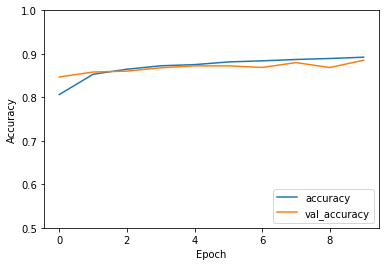

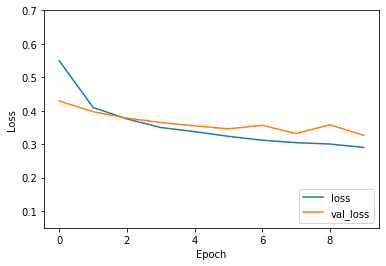

In [61]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.05, .7])
plt.legend(loc='lower right')
plt.show()

We can see that the model is overfitting because test accuracy is lower than training accuracy. However, the model is not overfitting by a tremendous amount.

Since this is a beginning book, we will do very little model tuning. **Tuning** is the process of maximizing a model's performance without overfitting or creating too high of a variance. Simple tuning is pretty easy, but sophisticated tuning is definitly an advanced topic.

A very simple, but powerful way to tune a model is to use dropout. **Dropout** is a regularization method that approximates training a large number of neural networks with different architectures in parallel. Reading the definition doesn't make it easier to understand for a beginner. So, let's explain how it works. 

During training, some number of layer outputs are randomly ignored or *dropped out*. By randomly dropping out layer outputs, effectively the layer looks like and is treated like a layer with a different number of nodes and connectivity to the prior layer. So, each update to a layer during training is performed with a different *view* of the configured layer.

We can also use Pandas to plot the history dictionary with just a few lines of code:

(0.0, 1.0)

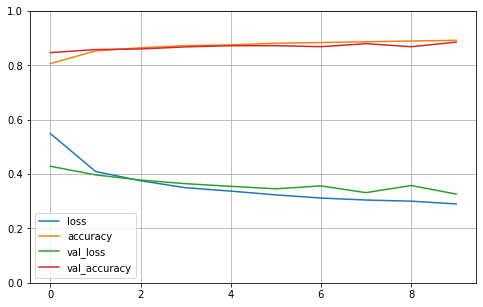

In [62]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

# Predict Labels for Test Images

Now that we have a trained model, we can make predictions based on the test images. We predict from the test images because the model sees these images as **new** data.

Let's begin by predicting the label for each image in the test set.

In [63]:
predictions = model.predict(test_ks)

For this dataset, a prediction is an array of 10 numbers that represent the model's *confidence* that the image corresponds to each of the 10 different articles of clothing.

Now, let's take a look at the first prediction from test_images:

In [64]:
predictions[0]

array([6.8871632e-06, 2.0354221e-06, 2.5226898e-06, 2.1808367e-07,
       3.4618131e-07, 3.1343404e-02, 1.3201673e-05, 7.0138842e-02,
       3.4364264e-05, 8.9845812e-01], dtype=float32)

Round values for convenience:

In [65]:
np.round(predictions[0], 2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.07, 0.  , 0.9 ],
      dtype=float32)

Directly access confidence in the prediction:

In [66]:
100*np.max(predictions[0])

89.84581232070923

Convert value to percentage:

In [67]:
str(np.round(100*np.max(predictions[0]), 2)) + '%'

'89.85%'

Now, let's display the prediction for the first image:

In [68]:
np.argmax(predictions[0])

9

The prediction can only be between **0** and **9** because our target class consists of ten classes. We can use the 'class_labels' array that we created earlier to see the actual fashion article as so:

In [69]:
class_labels[np.argmax(predictions[0])]

'Ankle boot'

Now, let's see the first actual test image so we can compare the two:

In [70]:
class_labels[test_labels[0]]

'Ankle boot'

If our prediction and the actual image match, we predicted correctly.

Let's make four predictions based on the test dataset: 

In [71]:
pred_4 = predictions[:4]

Show predictions:

In [72]:
ls = [np.argmax(row) for row in pred_4]
ls

[9, 2, 1, 1]

Get class labels of predictions:

In [73]:
np.array(class_labels)[ls]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser'], dtype='<U11')

Compare predictions to the test dataset:

In [74]:
actual_4 = test_labels[:4]
actual_4

array([9, 2, 1, 1], dtype=uint8)

Get class labels of actual images:

In [75]:
np.array(class_labels)[actual_4]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser'], dtype='<U11')

Let's visualize:

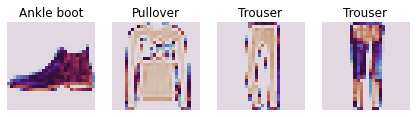

In [76]:
# slice off the first four images from the test data

img_4 = test_images[:4]

# plot images

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(img_4):
  plt.subplot(1, 4, index + 1)
  plt.imshow(image, cmap='twilight', interpolation='nearest')
  plt.axis('off')
  plt.title(class_labels[actual_4[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

## Explore Misclassifications

Let's explore the predictions and test images to find some misclassifications. The first step is to identify the prediction labels:

In [77]:
rng = (len(predictions))
y_pred = [np.argmax(row) for row in predictions]

The next step is the grab some predictions and actual targets:

In [78]:
# find first n predictions and actual targets

n = 20
y_n = [y_pred[i] for i, row in enumerate(range(n))]
y_actual = [test_labels[i] for i, row in enumerate(range(n))]

y_n, y_actual

([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0],
 [9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0])

Find misclassifications:

In [79]:
# compare predictions against actual targets

miss_indx_list = [index for index, (x, y) in
                  enumerate(zip(y_n, y_actual))
                  if x != y]

miss_indx_list

[12, 17]

If you don't get any misclassification, increase **n** size and rerun the last two code snippets!

So, we now have an array of misclassifications by their index. Now, let's see the confidence for each misclassifications:

In [80]:
# display confidence for each misclassfication:

for row in miss_indx_list:
  val = 100*np.max(predictions[row])
  rounded = str(round(val, 2)) + '%'
  print ('index:', row, 'confidence:', rounded,
         'pred:', class_labels[np.argmax(predictions[row])],
         'actual:', class_labels[test_labels[row]])

index: 12 confidence: 75.99% pred: Sandal actual: Sneaker
index: 17 confidence: 67.25% pred: Pullover actual: Coat


## Visualize Misclassifications

Create a function to visualize:

In [81]:
def see_misses(indx):
  plt.imshow(test_images[indx], cmap='nipy_spectral')
  plt.show()
  print ('actual:', class_labels[test_labels[indx]])
  print ('predicted:',
         class_labels[np.argmax(predictions[indx])])
  print ('confidence', rounded)

Invoke the function:

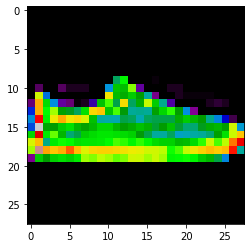

actual: Sneaker
predicted: Sandal
confidence 75.99%


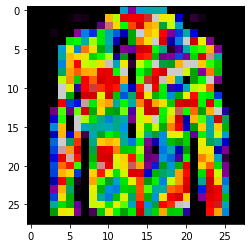

actual: Coat
predicted: Pullover
confidence 67.25%


In [82]:
for row in miss_indx_list:
  val = 100*np.max(predictions[row])
  rounded = str(round(val, 2)) + '%'
  see_misses(row)

Let's get a bit more fancy and create a more sophisticated visualization:

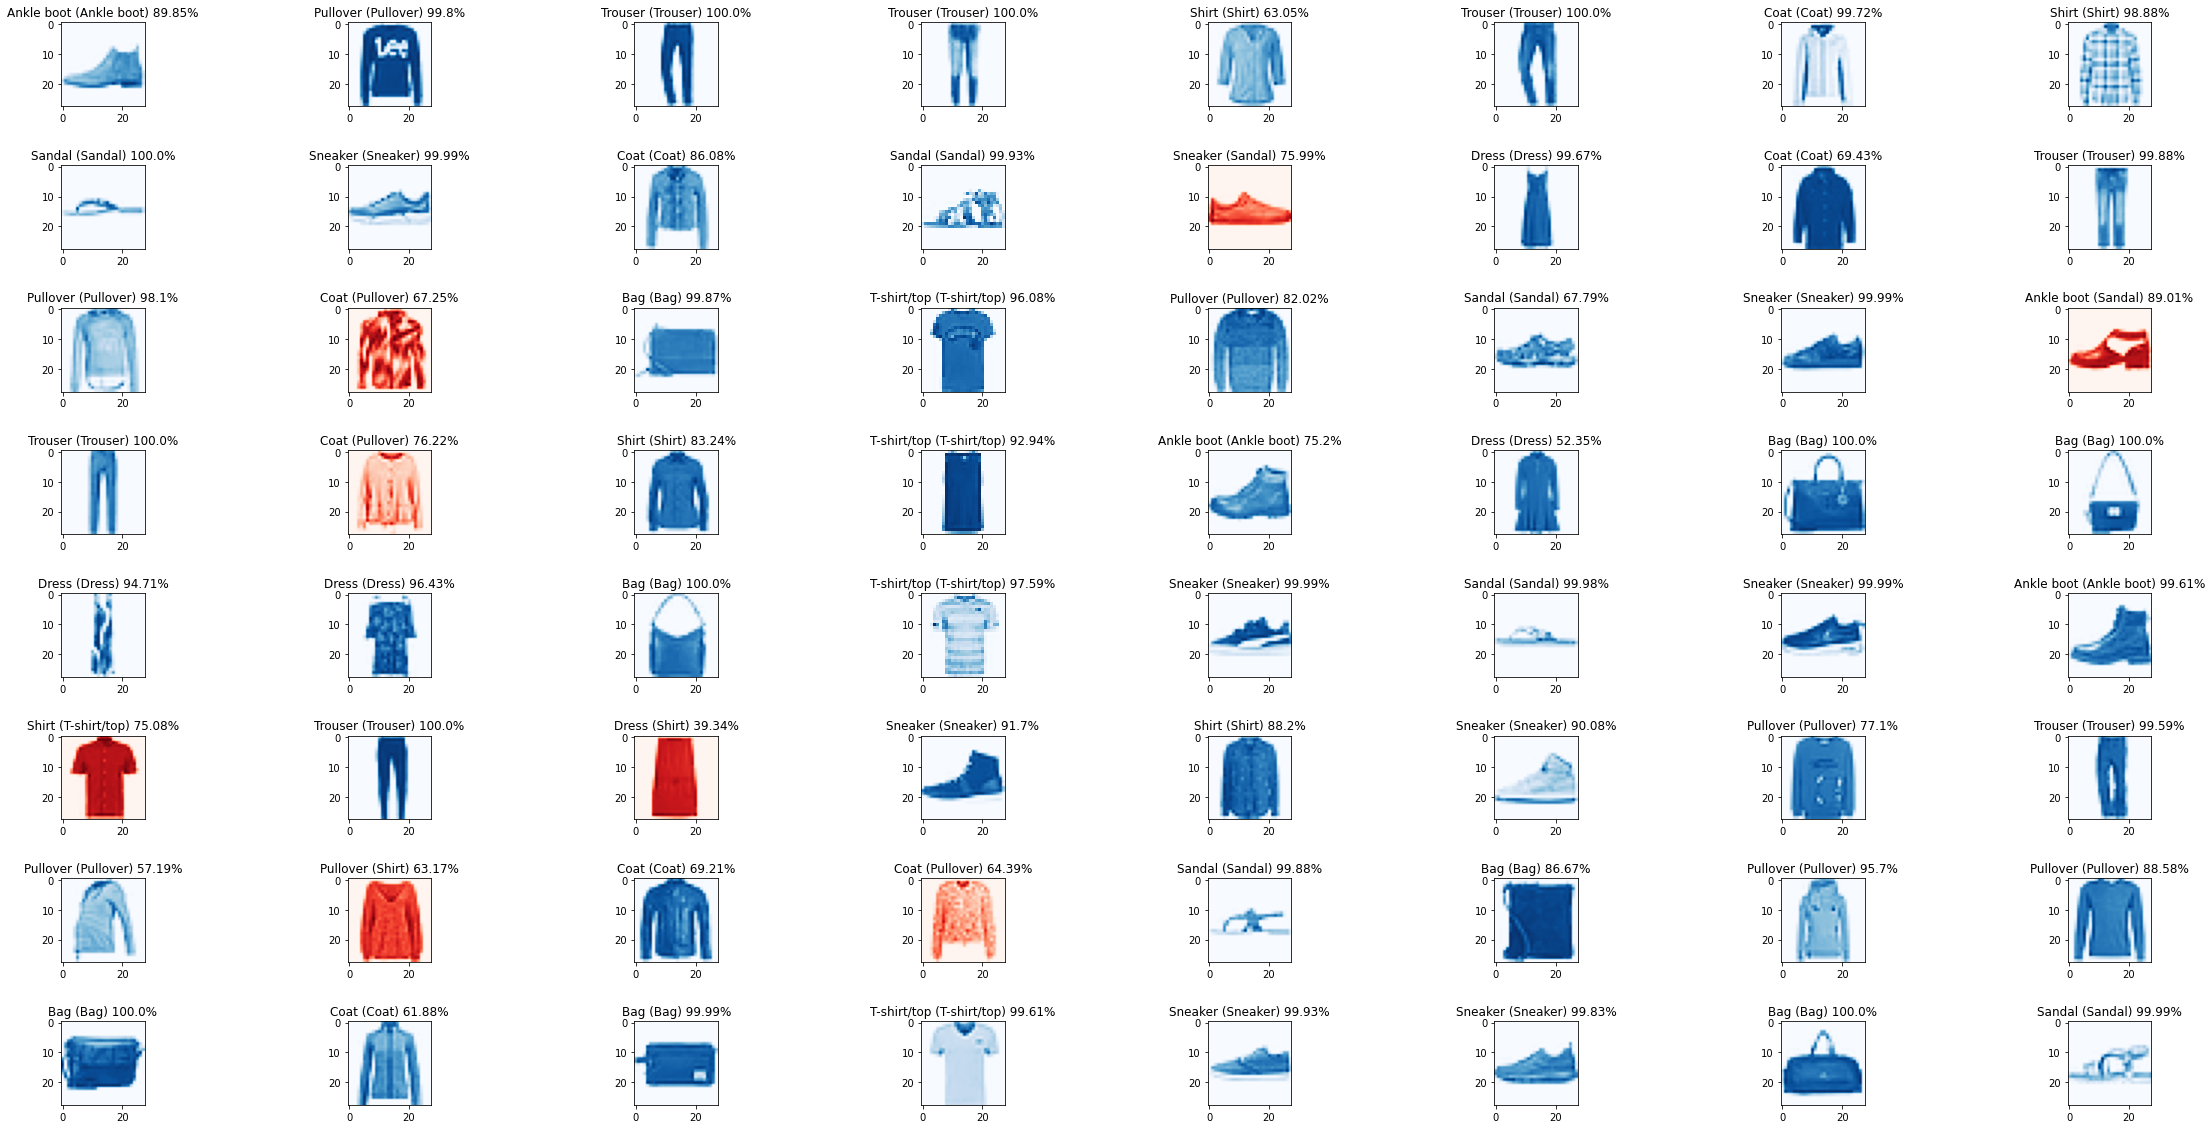

In [83]:
# Plot the first X test images, their true labels,
# their predicted labels, and prediction confidence.

num_rows = 8
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  if class_labels[test_labels[i]] != class_labels[y_pred[i]]:
    plt.imshow(test_images[i], cmap='Reds')
  else:
    plt.imshow(test_images[i], cmap='Blues')
  val = 100*np.max(predictions[i])
  rounded = str(np.round(val, 2)) + '%'
  plt.title(class_labels[test_labels[i]] + ' (' +\
            class_labels[y_pred[i]] + ') ' + rounded )
plt.tight_layout()
plt.show()

From this visualization, we can easily see misclassifications.

## Predict from a Single Image

Get a randomly generated number:

In [84]:
beg, end = 0, len(test_images) - 1
rng = np.random.default_rng()
indx = int(rng.uniform(beg, end, size=1))
indx

4306

In [85]:
# Grab the image from the test dataset

img = test_images[indx]
label = class_labels[test_labels[indx]]
img.shape, label

((28, 28), 'Shirt')

tf.keras models are optimized to make predictions on a batch or collection of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [86]:
img_batch = (np.expand_dims(img, 0))
img_batch.shape

(1, 28, 28)

Now, we can predict:

In [87]:
pred_single = model.predict(img_batch)

Display prediction:

In [88]:
np.argmax(pred_single)

6

Display prediction by label name:

In [89]:
class_labels[np.argmax(pred_single)]

'Shirt'

Display actual label:

In [90]:
class_labels[test_labels[indx]]

'Shirt'

Let's visualize:

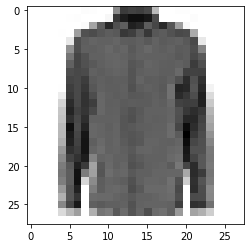

actual: Shirt
predicted: Shirt
confidence 87.12%


In [91]:
pred = class_labels[np.argmax(pred_single)]
actual = class_labels[test_labels[indx]]

# get confidence from the predictions object
val = 100*np.max(predictions[indx])
rounded = str(np.round(val, 2)) + '%'

# display actual image
plt.imshow(test_images[indx], cmap=plt.cm.binary)
plt.show()

print ('actual:', actual)
print ('predicted:', pred)
print ('confidence', rounded)

# Confusion Matrix

Create a confusion matrix to visually demonstrate how well our model classified the articles of clothing:

In [92]:
tf.math.confusion_matrix(test_labels, y_pred)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[902,   0,  14,  17,   5,   2,  56,   0,   4,   0],
       [  3, 972,   0,  18,   4,   0,   3,   0,   0,   0],
       [ 22,   2, 824,   7,  80,   0,  64,   0,   1,   0],
       [ 28,   8,  11, 909,  24,   0,  17,   0,   3,   0],
       [  0,   0, 117,  45, 779,   0,  57,   0,   2,   0],
       [  0,   0,   0,   0,   0, 959,   0,  32,   0,   9],
       [191,   1,  92,  27,  59,   1, 619,   0,  10,   0],
       [  0,   0,   0,   0,   0,   8,   0, 983,   0,   9],
       [  7,   0,   4,   5,   3,   1,   1,   4, 975,   0],
       [  0,   0,   0,   0,   0,   9,   1,  58,   0, 932]], dtype=int32)>

Create a fancy confusion matrix:

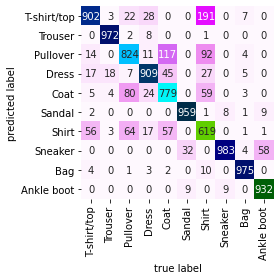

In [93]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, y_pred)
plt.figure('confusion matrix')
sns.heatmap(cm.T, square=True, annot=True, fmt='d',
                cmap='gist_ncar_r',
                xticklabels=class_labels,
                yticklabels=class_labels, cbar=False)

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.tight_layout()
plt.show()

Correct classifications are along the diagonal. Misclassifications are not on the diagonal. For an excellent explanation of a confusion matrix, please peruse the following URL:

https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

# Number of Hidden Layers

For many problems, we can begin with a single hidden layer and get reasonable results as we did with our Fashion-MNIST model in this chapter. For more complex problems, however, we should add layers until we start overfitting the training set. Since this book is for beginners, we won't venture into highly complex tasks. But, as you gain proficiency with neural network modeling, you will definitely face much more complex tasks.  

# Number of Neurons in Hidden Layers

The number of neurons in the input and output layers is based on the type of input and output your task requires. For example, the Fashion-MNIST task requires 28 x 28 = 784 input neurons and 10 output neurons. For hidden layers, it is very difficult to determine. You can try increasing the number of neurons gradually until the network starts overfitting. In practice, we typically pick a model with more layers and neurons than we need and then use early stopping and other regularization techniques to reduce overfitting. Again, this being a beginning book, we won't delve any deeper into tuning networks.

Generally, we get a better model by increasing the number of layers rather than the number of neurons per layer. Of course, the number of layers and neurons we include is limited by our computational resources available.